In [109]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import make_pipeline  as imb_make_pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, f1_score, auc, accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve

from prettytable import PrettyTable

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../data/default-of-credit-card-clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df.drop(columns=['ID'],inplace=True)

## Feature Engineering

In [5]:
round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)

# get the first seven rows

default payment next month    1.00
PAY_1                         0.32
PAY_2                         0.26
PAY_3                         0.24
PAY_4                         0.22
PAY_5                         0.20
PAY_6                         0.19
LIMIT_BAL                     0.15
PAY_AMT1                      0.07
PAY_AMT2                      0.06
PAY_AMT3                      0.06
PAY_AMT4                      0.06
PAY_AMT5                      0.06
PAY_AMT6                      0.05
SEX                           0.04
EDUCATION                     0.03
MARRIAGE                      0.02
BILL_AMT1                     0.02
AGE                           0.01
BILL_AMT3                     0.01
BILL_AMT4                     0.01
BILL_AMT5                     0.01
BILL_AMT6                     0.01
BILL_AMT2                     0.01
Name: default payment next month, dtype: float64

In [6]:
low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
df_no_corr = df.drop(columns=low_corr_cols)

## Partitioning

In [4]:
y, X = df["default payment next month"], df.drop("default payment next month", axis=1)

random_state = 42


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    stratify= y, random_state=random_state)

# drop the ones with a low correlation??

In [64]:
y, X = df["default payment next month"], df_no_corr.drop("default payment next month", axis=1)

random_state = 42
ts = 0.25


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    stratify= y, random_state=random_state)

# drop the ones with a low correlation??

## Methods

In [80]:
def report(y_true, y_pred, title = "", 
           params = None, show_cm = True, show_params = True):

    nl = '\n'
    sp = "*"*len(title)
    
#     print("__"*30 + nl)
    if title:
        title = "Classification report for " + title + " on yet-unseen data"
        sp = "*"*len(title)
        print(sp + nl + title + nl + sp +nl)
    
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    print("Accuracy: {:.3f}".format(acc))
    print("f-score: {:.3f}".format(f_score))
    
    if params and show_params:
        new_params = {}
        for k in params:
            new_params[k.split("__")[-1]] = params[k]
            
        print("\nBest Parameters:")
#         pprint(new_params, indent = 4)
        print(grid_search.best_estimator_)
        
#     print(classification_report(y_true, y_pred))
    if show_cm:
        plt.figure(figsize = (6,5))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, 
                    cmap = 'YlGnBu', 
                    annot_kws={"size": 18},
                    linecolor = 'w',
                    linewidth = 4
                   )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
    
    return (acc, f_score)
    
scores_dict = {}
gs_trained_models =  {}

# Pipeline

In [153]:
def outliers_iqr(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1
    
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    y = df_out["default payment next month"]
    X = df_out.drop(columns=["default payment next month"])
    
    print(y)
    print(Counter(y))
    
    return X, y

def outliers_lof(X, y, n_neighbors=20):
        
    y = np.asarray(y)
    X = np.asarray(X)

    outliers = LocalOutlierFactor(n_neighbors = n_neighbors, n_jobs = -1).fit_predict(X)
    X = X[outliers == 1, :]
    y = y[outliers == 1]

    return X, y

In [86]:
random_state = 42

scaler = StandardScaler()

pca = PCA(n_components=11, random_state=random_state)

under_s = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)
over_s = SMOTE(sampling_strategy=0.5, random_state=random_state)
smoteenn = SMOTEENN(random_state=random_state)

cases = []

params = {
    "randomforestclassifier" : {
        "randomforestclassifier__n_estimators":[80,100,120],
        "randomforestclassifier__criterion":["gini", "entropy"],
        "randomforestclassifier__max_depth":[8,10,12],
        "randomforestclassifier__min_samples_split":[2,4,6],
        "randomforestclassifier__max_features":['sqrt','log2'],
    },
    "svc" : {
        "svc__kernel": ['linear', 'rbf', 'poly'],
        "svc__gamma" :['scale', 'auto'],
        "svc__tol": [1e-2,1e-3,1e-4],
        "svc__C": [0.5,0.8, 1.0,1.2, 1.5] 
    },
    "knn" : {
        "n" : [3,5,7,9]
    }
}

In [143]:
smoteenn

SMOTEENN(random_state=42)

In [156]:
features_filtering = [False]
pca_options = [False]
outliers_options = [None, "iqr", "lof"]
resampling_options = [None, under_s,over_s,smoteenn]

y, X = df["default payment next month"], df.drop("default payment next month", axis=1)

random_state = 42

table = PrettyTable()

table.title = 'Results for RandomForest'
table.field_names = ['Preprocessing','Accuracy','F1']

# do it with or without features filtering
# now : with feature filtering
for pca_opt in pca_options:
    for outliers_opt in outliers_options:
        for resampling_opt in resampling_options:
            field_0 = ''
            if outliers_opt:
                
                if outliers_opt == "iqr":
                    X, y = outliers_iqr(df)
                    field_0 = 'IQR + '
                    print("here")

                if outliers_opt == "lof":
                    X, y = outliers_lof(df)
                    field_0 = 'LOF + '
                    print("Here 2")
            else:
                field_0 = ''

            if pca_opt and resampling_opt:
                field_0 += f'Scaling + PCA'
                pipeline = imb_make_pipeline(scaler,pca,resampling_opt,models["randomforestclassifier"])

            elif not pca_opt and resampling_opt:
                field_0 += f'Scaling'
                pipeline = imb_make_pipeline(scaler,resampling_opt,models["randomforestclassifier"])

            elif pca_opt and not resampling_opt:
                field_0 += f'Scaling + PCA'
                pipeline = make_pipeline(scaler,pca,models["randomforestclassifier"])

            elif not pca_opt and not resampling_opt:
                field_0 += f'Scaling'
                pipeline = make_pipeline(scaler,models["randomforestclassifier"])
                
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    stratify= y, random_state=random_state)
            
            pipeline.fit(X_train, y_train)
            y_predicted = pipeline.predict(X_test)
            
            accuracy = accuracy_score(y_test,y_predicted)
            f1 = f1_score(y_test,y_predicted)
            
            table.add_row([field_0, round(accuracy,4), round(f1,4)])        
            
print(table)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (3829, 35046) and data type float64

In [67]:
models = {
    "randomforestclassifier" : RandomForestClassifier(random_state=random_state),
    "knn" : KNeighborsClassifier
    "svm" : SVC(),
} 

In [82]:
%time 

pipeline = make_pipeline(StandardScaler(), models["randomforestclassifier"])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=random_state)

grid_search = GridSearchCV(pipeline, params["randomforestclassifier"],
                               scoring = 'f1',
                               n_jobs=-1,
                               cv=stratified_kfold,
                    )
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_estimator_

Wall time: 0 ns


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='sqrt',
                                        min_samples_split=4,
                                        random_state=42))])

*******************************************************************
Classification report for RandomForestClassifier on yet-unseen data
*******************************************************************

Accuracy: 0.818
f-score: 0.467

Best Parameters:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='sqrt',
                                        min_samples_split=4,
                                        random_state=42))])


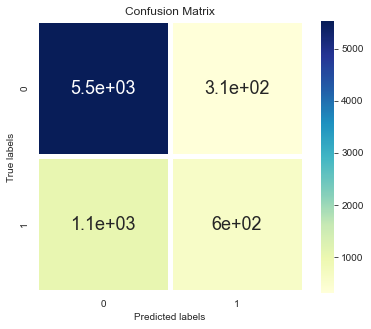

In [83]:
acc, fscore = report(y_test, y_pred, "RandomForestClassifier", grid_search.best_params_, True, True)
scores_dict["RandomForestClassifier"] = fscore